In [1]:
%matplotlib inline
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"]="1"
os.environ["CUDA_VISIBLE_DEVICES"]="" # Make sure we are not using GPU, but we CAN and should use GPU during training.
import numpy as np
import keras
from keras.layers import Input, Conv2D, Activation, UpSampling2D
from keras.layers.core import Dropout, Reshape
from keras.layers.normalization import BatchNormalization
from keras.models import Model, load_model
from keras.models import *
from keras.layers import *
from keras.optimizers import Adam
import cv2
import matplotlib.pyplot as plt
import glob
import imgaug as ia
from imgaug import augmenters as iaa
from time import time

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

# Prepare model

First, we define a depthwise convolutional block since we will be reusing this block many times. This block consists of depthwise convolution, batch normalization, activation, and pointwise convolution layers. For those who are not yet familiar with the concept of depthwise and pointwise convolutional layers, we recommend to read the MobileNets paper (https://arxiv.org/abs/1704.04861) and this great blog (https://towardsdatascience.com/a-basic-introduction-to-separable-convolutions-b99ec3102728).

In [2]:
def depthwise_conv2d_block(inp, pointwise_filters, depthwise_strides=(1, 1)):
    x = DepthwiseConv2D((3, 3),
                        padding='same',
                        strides=depthwise_strides
                       )(inp)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(pointwise_filters,
               (1, 1),
               padding='same',
               strides=(1, 1))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

 Now, let's define our model. We follow the architecture of FCN (https://people.eecs.berkeley.edu/~jonlong/long_shelhamer_fcn.pdf) which consists of encoder and decoder with skip connections. Nevertheless, there is no right or wrong answer here, so please feel free to play with the architecture.

In [3]:
num_class = 6

# Start with the encoder
inp = Input(shape=(120, 160, 3))
x = Conv2D(32, (3,3),
           padding='same',
           strides=(2,2))(inp)
x = BatchNormalization()(x)
x = Activation('relu')(x)
out_1 = depthwise_conv2d_block(x, 64)
x = depthwise_conv2d_block(out_1, 96, depthwise_strides=(2,2))
out_2 = depthwise_conv2d_block(x, 96)
x = depthwise_conv2d_block(out_2, 224, depthwise_strides=(2,2))
x = depthwise_conv2d_block(x, 224)
out_3 = depthwise_conv2d_block(x, 224)

# Decoder with skip connections
x = (Conv2D(384, (3,3), activation='relu',padding='same'))(out_3)
x = Dropout(0.5)(x)
x = UpSampling2D()(x)
x = Conv2D(num_class, kernel_size=(3,3), kernel_initializer='he_normal', padding='same')(x)
x_ = Conv2D(num_class,  (1, 1), kernel_initializer='he_normal', padding='same')(out_2)
x = Add()([x, x_])
x = UpSampling2D()(x)
x = Conv2D(num_class, kernel_size=(3,3), kernel_initializer='he_normal', padding='same')(x)
x_ = Conv2D(num_class,  (1, 1), kernel_initializer='he_normal', padding='same')(out_1)    
x = Add()([x, x_])
x = UpSampling2D()(x)


x = Conv2D(num_class, kernel_size=(6,6), kernel_initializer='he_normal', padding='same')(x)
x = Reshape((-1, 6))(x)
x = Activation('softmax')(x)

model = Model(inp, x)

lr = 1e-5
model.compile(loss='sparse_categorical_crossentropy', 
              optimizer=Adam(lr),
              metrics=["accuracy"])







Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.




Note that we use `sparse_categorical_crossentropy` as our loss. This means we expect the label for the image to be a vector with length = `image_height` x `image_width` x 1, and each element in this vector is an integer between 0 and number of classes minus 1, which corresponds to the correct class ID for each pixel. For example, if we have 6 classes, then each element in this vector is a number between 0 to 5.

# Test model speed on CPU

Now, let's see how fast our model can process an image of size 120 x 160 x 3 on CPU.

Average time per frame: 0.01 seconds


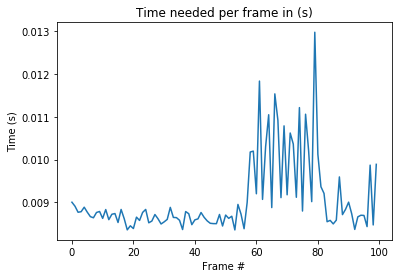

In [4]:
t = []
dummy_inp = np.random.random((1,120,160,3))
model.predict(dummy_inp)
for i in range(100):
    start_time = time()
    model.predict(dummy_inp)
    t_elapsed = time() - start_time
    t.append(t_elapsed)

plt.plot(t)
plt.title('Time needed per frame in (s)')
plt.xlabel('Frame #')
plt.ylabel('Time (s)')
print('Average time per frame: %.2f seconds' % (np.sum(t)/len(t)))

Fast enough! We can definitely use this for AIDO challenges :)

# Data loader

In [5]:
# Define color code for each class, we have 6 classes.
black = np.array([0,0,0]) # class 0 (road/sky/others)
yellow = np.array([1,1,0]) # class 1 (yellow line)
white = np.array([1,1,1]) # class 2 (white line)
green = np.array([0,1,0]) # class 3 (obstacles)
red = np.array([1,0,0]) # class 4 (duckiebot)
purple = np.array([1,0,1]) # class 5 (red line)

img_path = '/home/rey/Documents/datasets/duckietown/rgbdata_160_120/'
label_path = '/home/rey/Documents/datasets/duckietown/processed_label_160_120/'

fnames = []
for fpath in sorted(glob.glob(img_path + '*.jpg')):
    fname = fpath.split('rgbdata_160_120/')[1]
    fnames.append(fname)

In [6]:
def color_segmap(segmap):
    '''
    To visualize segmentation map as an image.
    '''
    colored_segmap = np.zeros((segmap.shape[0],segmap.shape[1],3))
    for r in range(segmap.shape[0]):
        for c in range(segmap.shape[1]):
            if segmap[r,c] == 0:
                colored_segmap[r,c,:] = black
            elif segmap[r,c] == 1:
                colored_segmap[r,c,:] = yellow
            elif segmap[r,c] == 2:
                colored_segmap[r,c,:] = white
            elif segmap[r,c] == 3:
                colored_segmap[r,c,:] = green
            elif segmap[r,c] == 4:
                colored_segmap[r,c,:] = red
            elif segmap[r,c] == 5:
                colored_segmap[r,c,:] = purple
    return colored_segmap

Next, let's use imgaug to do domain randomization. The documentation for imgaug can be found here: https://imgaug.readthedocs.io/en/latest/

In [7]:
# For domain randomization
augmenter = iaa.Sequential([
    iaa.Sometimes(0.5,iaa.AddToHueAndSaturation((-20, 20))),  # change their color
    iaa.Sometimes(0.5,iaa.ElasticTransformation(alpha=90, sigma=14)),  # water-like effect
    iaa.Sometimes(0.5,iaa.GaussianBlur(sigma=(0, 1.2))),
    iaa.Sometimes(0.5,iaa.ContrastNormalization((0.2, 1.5))),
    iaa.Sometimes(0.5,iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5)),
    iaa.Sometimes(0.5,iaa.Sharpen(alpha=(0, 0.8), lightness=(0.75, 1.5))),
    iaa.Sometimes(0.5,iaa.Emboss(alpha=(0, 0.8), strength=(0, 1.0))),
    iaa.Sometimes(0.5,iaa.Add((-10, 10), per_channel=0.5)),
    iaa.Sometimes(0.5,iaa.Multiply((0.3, 1.5), per_channel=0.5)),
], random_order=True)

In [8]:
def load_batch(img_path,label_path,fnames,bs,augmenter):
    '''
    To load training and validation batches.
    '''
    batch_x_train = [] 
    batch_x_val = []
    batch_y_train = [] 
    batch_y_val = []
    for i in range(bs):
        # Pick random data index
        train_idx = np.random.randint(0, high = len(fnames))
        val_idx = np.random.randint(0, high = len(fnames))
        
        # Load train image + randomize + append
        train_fname = fnames[train_idx].split('.jpg')[0]
        train_im_fpath = img_path + train_fname + '.jpg'
        train_im = cv2.imread(train_im_fpath)[:,:,::-1]
        train_im = augmenter.augment_image(train_im) # apply random transformation
        train_im = train_im / 255.
        batch_x_train.append(train_im)
        
        # Load train label + format + append
        train_label_fpath = label_path + train_fname + '.npy'
        train_label = np.load(train_label_fpath)
        batch_y_train.append(train_label)
        
        # Load val image
        val_fname = fnames[val_idx].split('.jpg')[0]
        val_im_fpath = img_path + val_fname + '.jpg'
        val_im = cv2.imread(val_im_fpath)[:,:,::-1]
        val_im = augmenter.augment_image(val_im) # apply random transformation
        val_im = val_im / 255.
        batch_x_val.append(val_im)
        
        # Load val label + format + append
        val_label_fpath = label_path + val_fname + '.npy'
        val_label = np.load(val_label_fpath)
        batch_y_val.append(val_label)
        
    return np.array(batch_x_train),np.array(batch_x_val),np.array(batch_y_train),np.array(batch_y_val)

Let's sample some batches and see if the image-label pairs are as expected

(8, 120, 160, 3) (8, 120, 160, 3) (8, 19200, 1) (8, 19200, 1)


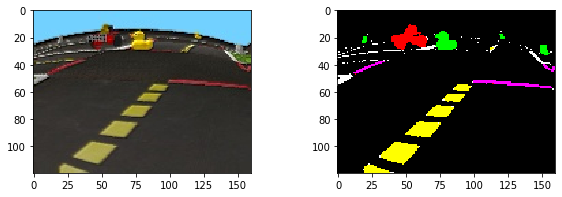

In [30]:
'''TEST DATALOADER'''
bs = 8
batch_x_train, batch_x_val, batch_y_train, batch_y_val = load_batch(img_path,label_path,fnames,bs,augmenter)
print(batch_x_train.shape, batch_x_val.shape, batch_y_train.shape, batch_y_val.shape)

b = 0
plt.figure(figsize = (10,3))

plt.subplot(121)
plt.imshow(batch_x_train[0])

plt.subplot(122)
batch_y_train_reshaped = np.reshape(batch_y_train[0],(batch_x_train.shape[1],batch_x_train.shape[2]))
batch_y_train_reshaped = color_segmap(batch_y_train_reshaped)
plt.imshow(batch_y_train_reshaped)

plt.show()

# Train model

In [34]:
num_iter = 200 # number of iterations (modify this!)
bs = 8 # batch size
model_name = 'ckpt'
training_losses = [] # to store training loss per iteration
validation_losses = [] # to store valicdation loss per iteration

In [35]:
for i in range(len(training_losses),num_iter):
    
    '''Learning rate scheduler'''
    if i%2000 == 0 and i != 0:
        lr = lr / 2.0
        model.optimizer = Adam(lr)
        
    '''Get batch'''
    batch_x_train, batch_x_val, batch_y_train, batch_y_val = load_batch(img_path,label_path,fnames,bs,augmenter)
    
    '''Train on train batch'''
    training_losses.append(model.train_on_batch(batch_x_train, batch_y_train))
    
    '''Test on val batch'''
    validation_losses.append(model.test_on_batch(batch_x_val, batch_y_val))
    
    '''Show losses'''
    if i%10 == 0:
        print('Iteration#%d train_loss = %.4f, val_loss = %.4f' % (i, training_losses[len(training_losses)-1][0], validation_losses[len(validation_losses)-1][0]))
    
    '''Save model periodically'''
    if i%2000 == 0 and i != 0:
        fname = model_name + str(i) + '.h5'
        model.save(fname)

Iteration#0 train_loss = 1.7464, val_loss = 1.3841
Iteration#10 train_loss = 1.3846, val_loss = 1.3983
Iteration#20 train_loss = 1.2754, val_loss = 1.0184
Iteration#30 train_loss = 1.0465, val_loss = 1.1676
Iteration#40 train_loss = 1.3046, val_loss = 0.8715
Iteration#50 train_loss = 0.9346, val_loss = 0.7810
Iteration#60 train_loss = 1.0333, val_loss = 0.7096
Iteration#70 train_loss = 1.0787, val_loss = 0.7852
Iteration#80 train_loss = 0.9841, val_loss = 0.7142
Iteration#90 train_loss = 0.8896, val_loss = 0.7136
Iteration#100 train_loss = 0.8650, val_loss = 0.8713
Iteration#110 train_loss = 0.7989, val_loss = 0.8486
Iteration#120 train_loss = 0.9210, val_loss = 0.7871
Iteration#130 train_loss = 0.7049, val_loss = 0.9231
Iteration#140 train_loss = 0.9371, val_loss = 0.6450
Iteration#150 train_loss = 0.8733, val_loss = 0.7073
Iteration#160 train_loss = 0.7655, val_loss = 0.9992
Iteration#170 train_loss = 0.9941, val_loss = 0.9091
Iteration#180 train_loss = 0.6837, val_loss = 0.8006
Iter

# Plot losses

We can see how our model did during training by plotting its losses.

In [36]:
training_losses_ = []
validation_losses_ = []
for i in range(len(training_losses)):
    training_losses_.append(training_losses[i][0])
    validation_losses_.append(validation_losses[i][0])

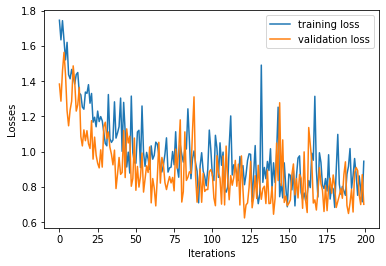

In [37]:
plt.plot(training_losses_)
plt.plot(validation_losses_)
plt.xlabel('Iterations')
plt.ylabel('Losses')
plt.legend(['training loss', 'validation loss'])
plt.show()

# Test segmentation model

Finally, we can test our model and see how the output looks like.

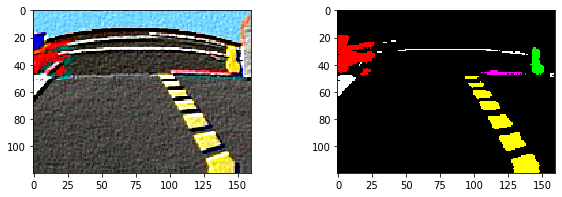

In [18]:
test_batch, _, _, _ = load_batch(img_path,label_path,fnames,bs,augmenter)
test_inp = np.expand_dims(test_batch[0],0)
predictions = model.predict(test_inp)

p_img = np.argmax(predictions, axis=-1) # (1, 19200)
p_img = np.reshape(p_img,(test_inp.shape[1],test_inp.shape[2]))
colored_p_img = color_segmap(p_img)

plt.figure(figsize = (10,3))

plt.subplot(121)
plt.imshow(test_inp[0])

plt.subplot(122)
plt.imshow(colored_p_img)

plt.show()

That is it, have fun!